In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [5]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [6]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [7]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [8]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [9]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [10]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [11]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [12]:
n=200
lr_list = os.listdir(r"C:\Users\srikanth\Desktop\SRGAN\lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread(r"C:\Users\srikanth\Desktop\SRGAN\lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir(r"C:\Users\srikanth\Desktop\SRGAN\hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread(r"C:\Users\srikanth\Desktop\SRGAN\hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


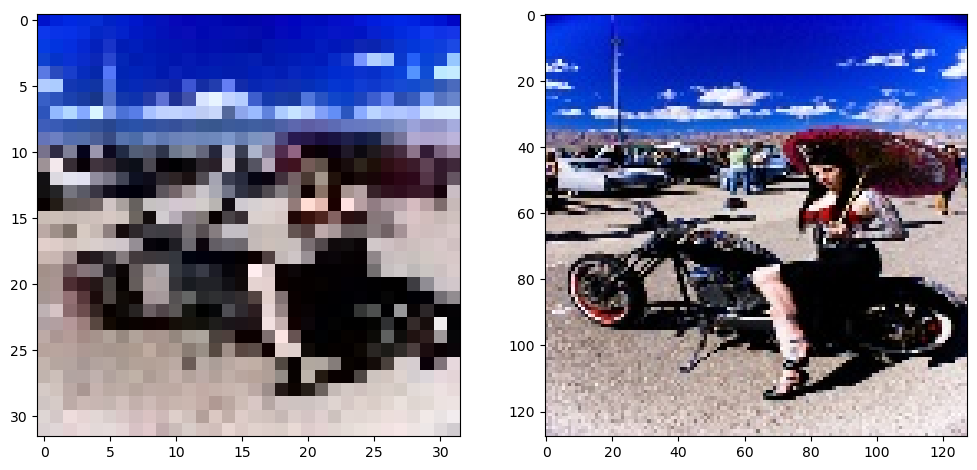

In [13]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [14]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [15]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [16]:

hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [17]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [18]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [19]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [20]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [21]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [23]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 4
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [24]:
epochs = 2
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    #if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
    generator.save("gen_e_"+ str(e+1) +".h5")

  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

1/1 [==============================] - 0s 455ms/step


  3%|██▌                                                                                | 1/33 [00:44<23:35, 44.23s/it]

1/1 [==============================] - 0s 291ms/step


  6%|█████                                                                              | 2/33 [00:52<11:56, 23.12s/it]

1/1 [==============================] - 0s 240ms/step


  9%|███████▌                                                                           | 3/33 [01:00<08:05, 16.18s/it]

1/1 [==============================] - 0s 235ms/step


 12%|██████████                                                                         | 4/33 [01:07<06:09, 12.74s/it]

1/1 [==============================] - 0s 228ms/step


 15%|████████████▌                                                                      | 5/33 [01:15<05:05, 10.90s/it]

1/1 [==============================] - 0s 217ms/step


 18%|███████████████                                                                    | 6/33 [01:23<04:27,  9.89s/it]

1/1 [==============================] - 0s 247ms/step


 21%|█████████████████▌                                                                 | 7/33 [01:31<04:01,  9.28s/it]

1/1 [==============================] - 0s 248ms/step


 24%|████████████████████                                                               | 8/33 [01:39<03:39,  8.78s/it]

1/1 [==============================] - 0s 238ms/step


 27%|██████████████████████▋                                                            | 9/33 [01:46<03:22,  8.43s/it]

1/1 [==============================] - 0s 246ms/step


 30%|████████████████████████▊                                                         | 10/33 [01:54<03:08,  8.18s/it]

1/1 [==============================] - 0s 231ms/step


 33%|███████████████████████████▎                                                      | 11/33 [02:02<02:57,  8.06s/it]

1/1 [==============================] - 0s 253ms/step


 36%|█████████████████████████████▊                                                    | 12/33 [02:10<02:48,  8.03s/it]

1/1 [==============================] - 0s 237ms/step


 39%|████████████████████████████████▎                                                 | 13/33 [02:18<02:40,  8.03s/it]

1/1 [==============================] - 0s 237ms/step


 42%|██████████████████████████████████▊                                               | 14/33 [02:26<02:31,  7.96s/it]

1/1 [==============================] - 0s 246ms/step


 45%|█████████████████████████████████████▎                                            | 15/33 [02:33<02:21,  7.86s/it]

1/1 [==============================] - 0s 250ms/step


 48%|███████████████████████████████████████▊                                          | 16/33 [02:41<02:13,  7.87s/it]

1/1 [==============================] - 0s 243ms/step


 52%|██████████████████████████████████████████▏                                       | 17/33 [02:49<02:05,  7.86s/it]

1/1 [==============================] - 0s 227ms/step


 55%|████████████████████████████████████████████▋                                     | 18/33 [02:57<01:58,  7.87s/it]

1/1 [==============================] - 0s 223ms/step


 58%|███████████████████████████████████████████████▏                                  | 19/33 [03:04<01:48,  7.76s/it]

1/1 [==============================] - 0s 248ms/step


 61%|█████████████████████████████████████████████████▋                                | 20/33 [03:12<01:39,  7.68s/it]

1/1 [==============================] - 0s 154ms/step


 64%|████████████████████████████████████████████████████▏                             | 21/33 [03:18<01:28,  7.34s/it]

1/1 [==============================] - 0s 232ms/step


 67%|██████████████████████████████████████████████████████▋                           | 22/33 [03:26<01:21,  7.43s/it]

1/1 [==============================] - 0s 218ms/step


 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [03:34<01:14,  7.48s/it]

1/1 [==============================] - 0s 251ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [03:42<01:08,  7.60s/it]

1/1 [==============================] - 0s 235ms/step


 76%|██████████████████████████████████████████████████████████████                    | 25/33 [03:49<01:01,  7.67s/it]

1/1 [==============================] - 0s 229ms/step


 79%|████████████████████████████████████████████████████████████████▌                 | 26/33 [03:57<00:53,  7.64s/it]

1/1 [==============================] - 0s 250ms/step


 82%|███████████████████████████████████████████████████████████████████               | 27/33 [04:05<00:45,  7.65s/it]

1/1 [==============================] - 0s 246ms/step


 85%|█████████████████████████████████████████████████████████████████████▌            | 28/33 [04:12<00:38,  7.69s/it]

1/1 [==============================] - 0s 263ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [04:20<00:30,  7.70s/it]

1/1 [==============================] - 0s 236ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [04:28<00:23,  7.73s/it]

1/1 [==============================] - 0s 246ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 31/33 [04:36<00:15,  7.76s/it]

1/1 [==============================] - 0s 247ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [04:43<00:07,  7.74s/it]

1/1 [==============================] - 0s 227ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [04:51<00:00,  8.83s/it]

epoch: 1 g_loss: 143.3700836644028 d_loss: [8.36377745 0.60606061]



  0%|                                                                                           | 0/33 [00:00<?, ?it/s]

1/1 [==============================] - 0s 241ms/step


  3%|██▌                                                                                | 1/33 [00:07<03:48,  7.16s/it]

1/1 [==============================] - 0s 212ms/step


  6%|█████                                                                              | 2/33 [00:14<03:47,  7.33s/it]

1/1 [==============================] - 0s 243ms/step


  9%|███████▌                                                                           | 3/33 [00:22<03:45,  7.51s/it]

1/1 [==============================] - 0s 246ms/step


 12%|██████████                                                                         | 4/33 [00:30<03:42,  7.67s/it]

1/1 [==============================] - 0s 273ms/step


 15%|████████████▌                                                                      | 5/33 [00:38<03:38,  7.80s/it]

1/1 [==============================] - 0s 252ms/step


 18%|███████████████                                                                    | 6/33 [00:45<03:25,  7.60s/it]

1/1 [==============================] - 0s 247ms/step


 21%|█████████████████▌                                                                 | 7/33 [00:53<03:18,  7.64s/it]

1/1 [==============================] - 0s 253ms/step


 24%|████████████████████                                                               | 8/33 [01:01<03:12,  7.69s/it]

1/1 [==============================] - 0s 223ms/step


 27%|██████████████████████▋                                                            | 9/33 [01:08<03:02,  7.61s/it]

1/1 [==============================] - 0s 241ms/step


 30%|████████████████████████▊                                                         | 10/33 [01:16<02:56,  7.67s/it]

1/1 [==============================] - 0s 240ms/step


 33%|███████████████████████████▎                                                      | 11/33 [01:24<02:49,  7.72s/it]

1/1 [==============================] - 0s 237ms/step


 36%|█████████████████████████████▊                                                    | 12/33 [01:31<02:42,  7.76s/it]

1/1 [==============================] - 0s 242ms/step


 39%|████████████████████████████████▎                                                 | 13/33 [01:39<02:35,  7.77s/it]

1/1 [==============================] - 0s 236ms/step


 42%|██████████████████████████████████▊                                               | 14/33 [01:47<02:27,  7.76s/it]

1/1 [==============================] - 0s 258ms/step


 45%|█████████████████████████████████████▎                                            | 15/33 [01:55<02:19,  7.75s/it]

1/1 [==============================] - 0s 248ms/step


 48%|███████████████████████████████████████▊                                          | 16/33 [02:02<02:11,  7.75s/it]

1/1 [==============================] - 0s 231ms/step


 52%|██████████████████████████████████████████▏                                       | 17/33 [02:10<02:03,  7.72s/it]

1/1 [==============================] - 0s 243ms/step


 55%|████████████████████████████████████████████▋                                     | 18/33 [02:18<01:54,  7.66s/it]

1/1 [==============================] - 0s 247ms/step


 58%|███████████████████████████████████████████████▏                                  | 19/33 [02:25<01:47,  7.71s/it]

1/1 [==============================] - 0s 244ms/step


 61%|█████████████████████████████████████████████████▋                                | 20/33 [02:33<01:39,  7.68s/it]

1/1 [==============================] - 0s 238ms/step


 64%|████████████████████████████████████████████████████▏                             | 21/33 [02:41<01:31,  7.66s/it]

1/1 [==============================] - 0s 231ms/step


 67%|██████████████████████████████████████████████████████▋                           | 22/33 [02:48<01:24,  7.65s/it]

1/1 [==============================] - 0s 253ms/step


 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [02:56<01:16,  7.63s/it]

1/1 [==============================] - 0s 248ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [03:04<01:08,  7.64s/it]

1/1 [==============================] - 0s 250ms/step


 76%|██████████████████████████████████████████████████████████████                    | 25/33 [03:11<01:01,  7.63s/it]

1/1 [==============================] - 0s 252ms/step


 79%|████████████████████████████████████████████████████████████████▌                 | 26/33 [03:19<00:53,  7.61s/it]

1/1 [==============================] - 0s 253ms/step


 82%|███████████████████████████████████████████████████████████████████               | 27/33 [03:26<00:45,  7.60s/it]

1/1 [==============================] - 0s 235ms/step


 85%|█████████████████████████████████████████████████████████████████████▌            | 28/33 [03:34<00:37,  7.58s/it]

1/1 [==============================] - 0s 247ms/step


 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [03:41<00:30,  7.61s/it]

1/1 [==============================] - 0s 246ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [03:49<00:22,  7.63s/it]

1/1 [==============================] - 0s 246ms/step


 94%|█████████████████████████████████████████████████████████████████████████████     | 31/33 [03:57<00:15,  7.65s/it]

1/1 [==============================] - 0s 256ms/step


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [04:05<00:07,  7.70s/it]

1/1 [==============================] - 0s 232ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [04:12<00:00,  7.67s/it]

epoch: 2 g_loss: 97.76834961862275 d_loss: [4.74247467 0.61742424]


In [2]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_2.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)



NameError: name 'lr_test' is not defined

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


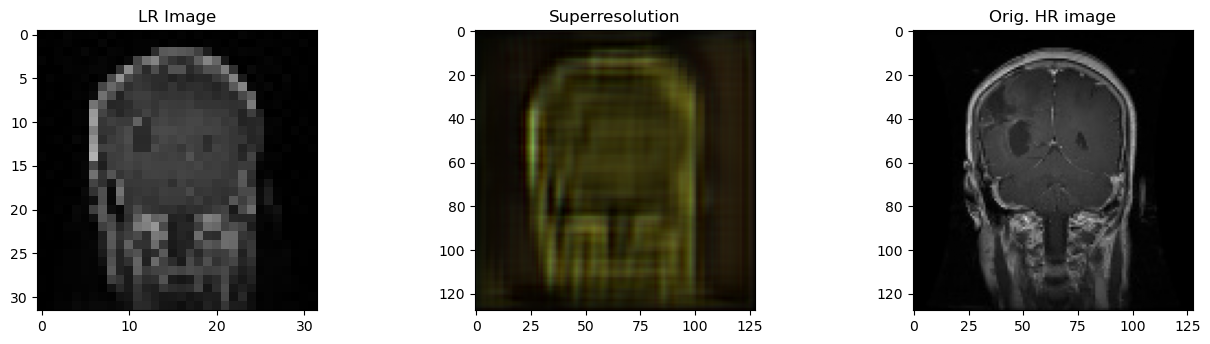

In [27]:


img_lr = cv2.imread("img1_32.jpeg")
img_hr = cv2.imread("img1_256.jpeg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
img_lr =  cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)

img_lr = img_lr / 255.
img_hr = img_hr / 255.

img_lr = np.expand_dims(img_lr, axis=0)
img_hr = np.expand_dims(img_hr, axis=0)

generated_img_hr = generator.predict(img_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(img_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_img_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(img_hr[0,:,:,:])

plt.show()

In [4]:
plt.title('Orig. HR image')
s=plt.imshow(img_hr[0,:,:,:])
s.save("org")

NameError: name 'plt' is not defined

In [35]:
pip install sewar


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10583 sha256=a200f86dd2845173def9301bb0e531a2e9e81d8d4a13023874960938295bb1dc
  Stored in directory: c:\users\srikanth\appdata\local\pip\cache\wheels\90\c1\d2\90faa299f5473d447a9a489377305840b7268c92b79bb5e000
Successfully built sewar


In [66]:
import numpy as np
import math
import cv2

def psnr(img1, img2):
    # Read images
    img1 = cv2.imread(img1)
    img2 = cv2.imread(img2)

    # Compute MSE
    mse = np.mean((img1 - img2) ** 2)

    # Compute PSNR using the formula
    psnr = 20 * math.log10(255 / math.sqrt(mse))

    return psnr


In [67]:
psnr_val=psnr('psnr1.png','psnr2.png')
print("PSNR",psnr_val)

ZeroDivisionError: float division by zero